## Determining The Relationship Between SAT Scores and Demographic Data across New York City Schools

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests, and whether they're unfair to certain groups. Our project will be investigating the correlations between [SAT scores](https://en.wikipedia.org/wiki/SAT) and demographics. We could correlate SAT scores with factors like race, gender, income, and more.

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the data set for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

New York City makes its [data on high school SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) available online, as well as the [demographics for each high school](https://data.cityofnewyork.us/Education/DOE-High-School-Directory-2014-2015/n3p6-zve2).

## Methodology

This analysis will use descriptive statistics (e.g. mean, correlations, z-score) and data visualizations (e.g. scatter plots, bar charts, maps) to explore the following datasets on NYC high schools:

Here are the links to all of the data sets we'll be using:

* [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

## Results
At the end of our analsis here are our findings:
* The higher the safe the school is as perceived by students, the higher the SAT Scores
* Schools with high percentage of students learning English have low SAT Scores i.e students who recently moved to the United States
* Students from Science, Technical and Liberal Arts Schools perform better in SAT Scores irespective of Safety, Race and Gender
* SAT Scores are not fair to Black and Hispanic students
* Asian students are highly represented with High SAT Scores

## Package Requirements
In this project we will be making use of the following pacages

* Pandas
* Numpy
* plotly
* Folium
* Seaborn
* Matplotlib
* Cufflinks

In [1]:
import tqdm
import warnings  # used here to surpress FutureWarning
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import folium
# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

### Reading in the data sets

In [2]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}
for f in data_files:
    d = pd.read_csv("data/{0}".format(f))
    data[f.replace(".csv", "")] = d
    
    
#Read in Survey Data
survey_all = pd.read_csv(r"C:\Users\LENOVO\Desktop\projects\nyc\data\survey_all.txt", delimiter="\t", encoding="windows-1252")
survey_d75 = pd.read_csv(r"C:\Users\LENOVO\Desktop\projects\nyc\data\survey_d75.txt", delimiter="\t", encoding="windows-1252")

#Combining the survey data
survey = pd.concat([survey_all, survey_d75], axis=0, sort="True")

#To standardize survey dbn column with our other datasets we need to change the column to DBN
survey["DBN"] =survey['dbn']

#Filtering our survey columns for just those columns relevant to our analysis
survey_fields = [
    "DBN",
    "rr_s",
    "rr_t",
    "rr_p",
    "N_s",
    "N_t",
    "N_p",
    "saf_p_11",
    "com_p_11",
    "eng_p_11",
    "aca_p_11",
    "saf_t_11",
    "com_t_11",
    "eng_t_11",
    "aca_t_11",
    "saf_s_11",
    "com_s_11",
    "eng_s_11",
    "aca_s_11",
    "saf_tot_11",
    "com_tot_11",
    "eng_tot_11",
    "aca_tot_11",
]

survey = survey.loc[:,survey_fields]

#Assigning Survey to dictionary data
data['survey'] = survey

In [3]:
#Standardizing dbn column in hs_directory dataset
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

#function to increase the len of value if length is less than 2
def padded(num):
    num = str(num)
    if len(num)  == 2:
        return num
    else:
        return num.zfill(0)
    
#Apply the function    
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(padded)

#Standardize class_size DBN column
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

#Converting to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

#Combining SAT scores
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

data['sat_results']['sat_score'].head()

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

In [4]:
#Extract latitude
def ext_lat(loc):
    coords = re.findall("\(.+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(ext_lat)

#Extract longitude
def ext_lon(loc):
    coords = re.findall("\(.+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(ext_lon)

#Convert to numeric
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

## Condensing Datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

In [6]:
#Computing Average class_size
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size
data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,10X080,10,25.000000,1.000000,25.000000,25.000000,25.000000,NaN
1,10X095,10,203.000000,8.000000,25.400000,19.000000,29.000000,NaN
2,10X118,10,197.000000,7.000000,28.100000,27.000000,31.000000,NaN
3,10X141,10,142.411765,5.176471,26.794118,21.352941,30.705882,NaN
4,10X206,10,324.000000,12.000000,27.000000,21.000000,32.000000,NaN


<b> Condensing Demographic Data set

In [7]:
data["demographics"] = data['demographics'][data["demographics"]['schoolyear'] == 20112012]

<b> Condensing Graduation Data set

In [8]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

<b> Converting AP to numeric

In [9]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for c in cols:
    data['ap_2010'][c] = pd.to_numeric(data['ap_2010'][c], errors='coerce')
    
#Check if data is correct    
data['ap_2010'].dtypes

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object

## Combining Our data sets

In [10]:
combined = data["sat_results"] 
combined = combined.merge(data['ap_2010'],how='left', on='DBN')
combined = combined.merge(data['graduation'], on='DBN', how='left')

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for d in to_merge:
    combined = combined.merge(data[d], on="DBN", how="inner")

## Filling in Missing Values

In [11]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [12]:
#Fucntion to extract first two characters
def ext_first_two_char(val):
    return val[0:2]

combined['school_district'] = combined['DBN'].apply(ext_first_two_char)

#Check if data is correct
print(combined["school_district"].head())

0    10
1    10
2    10
3    10
4    10
Name: school_district, dtype: object


In [13]:
survey_fields.remove('DBN')

## Survey Results: Survey Responses of Parents, Teachers and Students

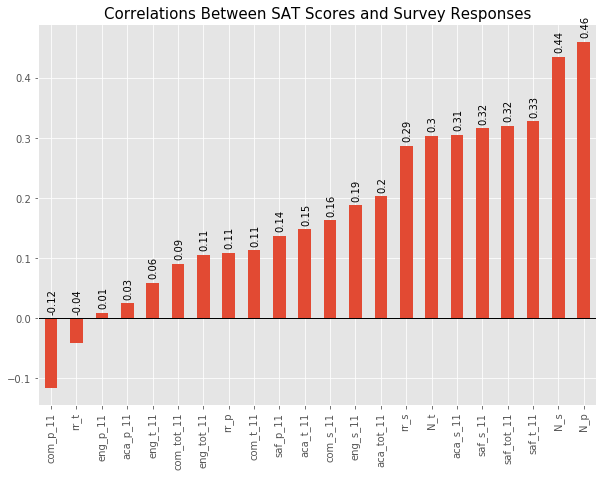

In [14]:
plt.style.use('ggplot')

plt.figure(figsize=(10,7))
ax = combined.corr()['sat_score'][survey_fields].sort_values().plot.bar()
plt.title('Correlations Between SAT Scores and Survey Responses', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x()+0.1, max(p.get_height(), 0)+0.01),
                rotation=90
                )
    
ax.axhline(y=0.0, color='black', linestyle='-', linewidth=1)
plt.show()

As shown in our visualization all Safety / Respect ("saf_...") and academic expectations of students ("aca_s_11") are correlated with good SAT scores.
This make sense, we can interprete thisto be __if students feel safe and have self trust / sets higher expectations, it can in turn make them become more focus on their studies__

Another surprising scenario is the aca_p_11, aca_t_11 and aca_s_11 academic expectation of parents, teachers and students where the expectation of parents and teachers has a very low correlaton with SAT scores to that of the students


<b> Exploring Safety

In [15]:
combined.iplot(x='saf_s_11', y='sat_score',
               categories='boro',text='SCHOOL NAME', 
               vline= {"x":combined["saf_s_11"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
               hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
               yTitle='SAT Scores',
               xTitle = 'Safety Scores',
               title = 'Correlation between Students Safety and Respect and SAT Score'
              )


The scatter plot above shows that schools with small safety scores below  6.5 has a low SAT scores below 1400 which make me conclude that when a school is not  secured they tend to perform bad in the SAT exam

<b> Plotting Safety by District

In [16]:
district = combined.groupby('school_district').mean()
district.reset_index(inplace=True)

In [17]:
import folium
import branca.colormap as cm

nyc_map = folium.Map(location=[40.693943, -73.985880], tiles='CartoDB positron', zoom_start=10)

#Adding title at the top of the map
#As seen on https://gitmemory.com/issue/python-visualization/folium/1202/527971941

title_html = '''
             <h3 align="center" style="font-size:20px"><b>New York City Schools: Average Safety Scores By District</b></h3>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))


# select column names of the viz parameters
size_parameter = "total_enrollment"
color_parameter = "saf_s_11"

# generate a colormap to shade the cirles on the map
# from https://stackoverflow.com/questions/56876620/unsure-how-to-use-colormap-with-folium-marker-plot
start_col_val = district[color_parameter].min()
end_col_val = district[color_parameter].max()

start_col_hex = '#e34a33' # used https://colorbrewer2.org/ 
end_col_hex = '#31a354'

colormap = cm.LinearColormap(colors=[start_col_hex,
                                     end_col_hex],
                             vmin=start_col_val,
                             vmax=end_col_val
                            )



colormap.caption = "Safety / Respect Score, students response"

# create a circle for each school district
for index, row in district.iterrows():
    folium.Circle(location=[row["lat"],row["lon"]],
                  color=colormap(row[color_parameter]),
                  fill_color=colormap(row[color_parameter]),
                  fill_opacity=0.75,
                  radius=row[size_parameter],
                  weight=2,
                  tooltip="District "+row["school_district"]+
                      " <br> Avg. Safety / Respect Score, students response (color): {:.1f}".format(row[color_parameter])+
                      " <br> Avg. enrollment per school (size): {:.0f}".format(row[size_parameter])
                 ).add_to(nyc_map)

# add a legend
nyc_map.add_child(colormap)
    
# display the map
nyc_map

### Racial Differences in Race

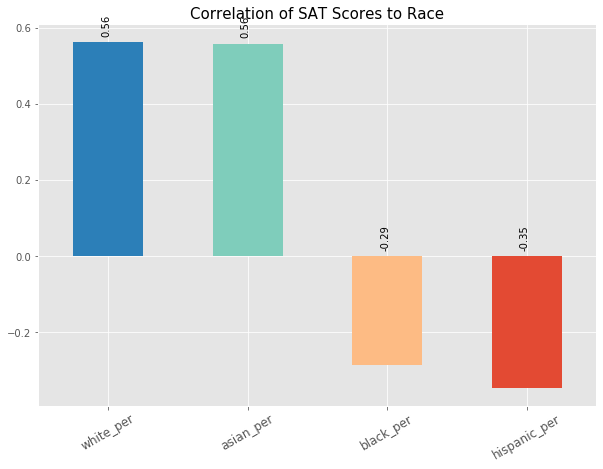

In [18]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
colors = [ '#2c7fb8', '#7fcdbb','#fdbb84','#e34a33']

ax = combined.corr()['sat_score'][races].sort_values(ascending=False).plot.bar(
    color=colors,
    figsize=(10, 7)
    
)
plt.title('Correlation of SAT Scores to Race', fontsize=15)
plt.xticks(rotation=30, fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

 # set data point labels
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x() + 0.2, max(p.get_height(), 0)+0.02),
                rotation=90
                )
plt.show()

The visualization above shows that higher perentage of asian and white students has a positive correlations to Sat Scores while Hispanic and Black students are negatively correlated with Hispanic being the highest negative correlation. With this we will explore hispanic more.

In [19]:

combined.iplot(
    x='hispanic_per',
    y='sat_score',
    text='SCHOOL NAME',
    categories='boro',
     vline= {"x":combined["hispanic_per"].mean(),
                "color":"#000000",
                "dash": "dash"
               },
               hline={"y":combined["sat_score"].mean(),
               "color":"#000000",
               "dash": "dash"
              },
               yTitle='SAT Scores',
               xTitle = '% of Hispanic Students',
               title = 'Correlation between % of Hispanic and Sat Score'
    

)


This scatter plot justify our check for correlation which indicate that SAT score and Hispanic_per race are negatively correlated.
The visualization above shows that SAT score does not favour hispanic dominating school. We can even see how school with less Hispanic students (less than 20%) perform far above SAT Score average 


In [20]:
#School dominated by Hispanic students
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

7                 INTERNATIONAL SCHOOL FOR LIBERAL ARTS
42     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
119                           MULTICULTURAL HIGH SCHOOL
152              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


__International School for Liberal Arts__ is a public school in the Bronx, NY, with a student-teacher ratio of 13 to 1. It is designed to offer Spanish-speaking teens a gentle transition to English.

__Pan American International High School at Monroe__ is a public school in the Bronx, NY, with a student-teacher ratio of 15 to 1. It offers new immigrants—including many unaccompanied minors—the chance to learn English and complete high school.

__Multicultural High School__ is a public school located in Brooklyn, NY, with a student-teacher ratio of 10 to 1. It serves Spanish-speaking students who have been in the United States for less than three years.

__Pan American International High School__ is a public school located in Elmhurst, NY, with a student-teacher ratio of 11 to 1. Students there all speak Spanish and have been in the United States for less than four years.

In summary the schools listed above appear to primarily be geared towards recent immigrants to the US as can been seen [here](https://en.wikipedia.org/wiki/The_Internationals_Network_for_Public_Schools). These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [21]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

17                          BRONX HIGH SCHOOL OF SCIENCE
53                        BROOKLYN TECHNICAL HIGH SCHOOL
193    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
222                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test. 

### Gender and SAT Scores

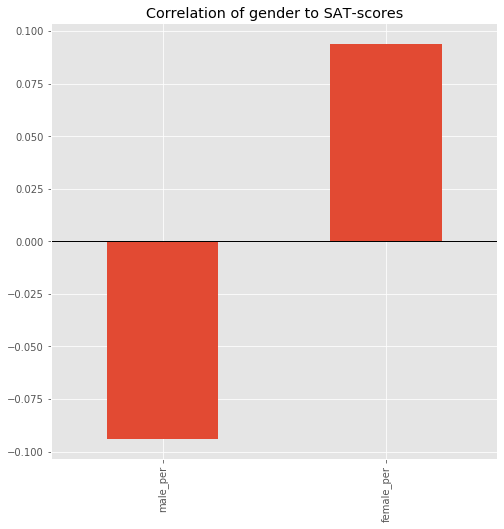

In [22]:
gender = ['male_per', 'female_per']

ax = combined.corr()['sat_score'][gender].plot(kind="bar",
                                                    figsize=(8, 8),
                                                    title="Correlation of gender to SAT-scores")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.axhline(y=0.0, color='black', linestyle='-', linewidth=1)
plt.show()

There is higher percenteage of females that positively correllate with SAT Score while that of male that negatively correlate is also high

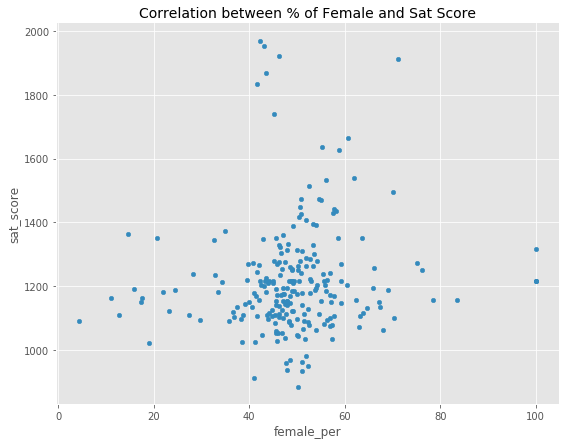

In [23]:

ax = combined.plot.scatter(x='female_per', y='sat_score', figsize=(9,7))
plt.title('Correlation between % of Female and Sat Score', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [24]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

168    TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Does Taking AP Exam Influences SAT Scores ?

In [25]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]*100

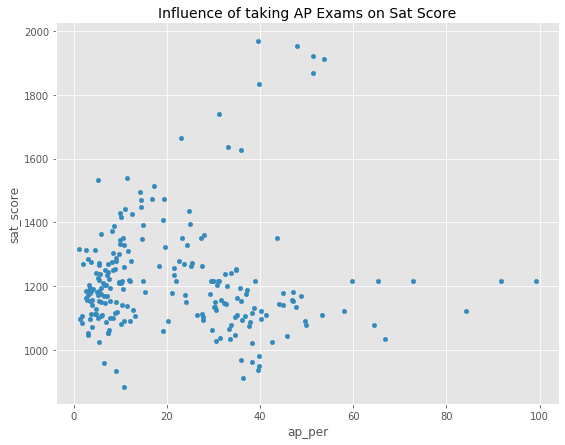

In [26]:
ax = combined.plot.scatter(x='ap_per', y='sat_score', figsize=(9,7))
plt.title('Influence of taking AP Exams on Sat Score', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


Our visualiation above shows there is correlation but not so strong correlation

In [27]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]*100

combined.iplot(
    x='ap_per',
    y='sat_score',
    
    categories='boro',
    xTitle='Percentage of AP test takers',
    yTitle='SAT Score',
    title='Correlation of Ap test takers and SAT Score')

There is relationship betwee SAT Score and the percentage of students that took the test in each school

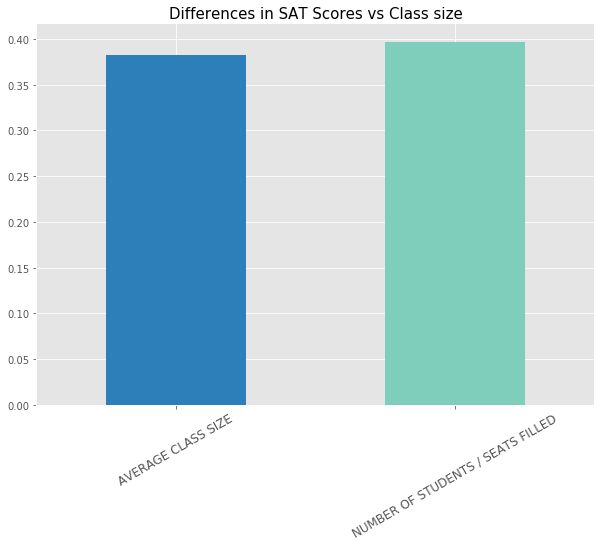

In [28]:
class_size = ['AVERAGE CLASS SIZE','NUMBER OF STUDENTS / SEATS FILLED']
combined.corr()['sat_score'][class_size].plot.bar()

colors = [ '#2c7fb8', '#7fcdbb']

ax = combined.corr()['sat_score'][class_size].plot.bar(
    color=colors,
    figsize=(10, 7)
    
)
plt.title('Differences in SAT Scores vs Class size', fontsize=15)
plt.xticks(rotation=30, fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Both average class size and number of students/seats filled are greatly correlated with SAT Scores

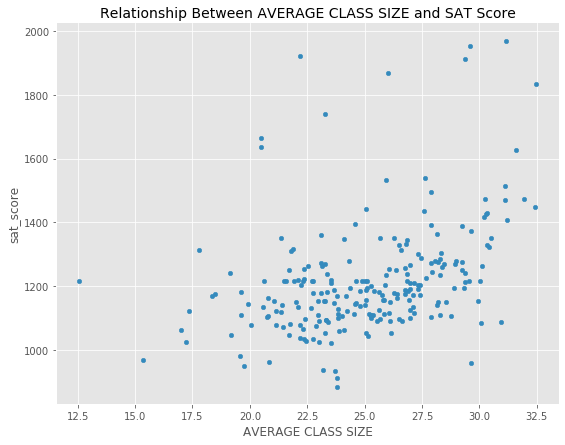

In [29]:

ax = combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score', figsize=(9,7))
plt.title('Relationship Between AVERAGE CLASS SIZE and SAT Score', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


It is obvious that the Average class size influences SAT Scores as the average class increases so does the SAT Scores increase

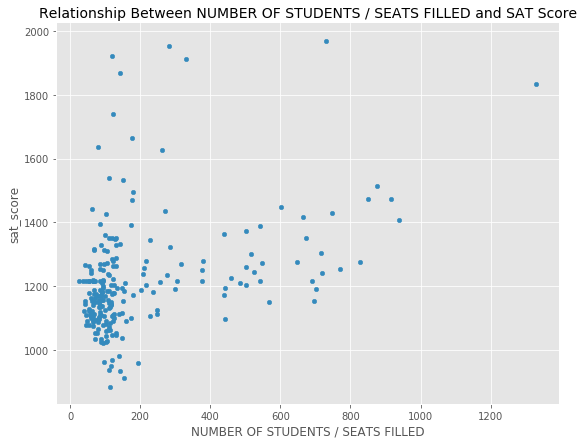

In [30]:
ax = combined.plot.scatter(x='NUMBER OF STUDENTS / SEATS FILLED', y='sat_score', figsize=(9,7))
plt.title('Relationship Between NUMBER OF STUDENTS / SEATS FILLED and SAT Score', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



There are some kind of correlation  between both SAT Scores and NUMBER OF STUDENTS / SEATS FILLED. However, there are schools with a very low numbers of students (0 to 200), and high SAT scores.

In [31]:
#schools with a very low numbers of students (0 to 200), and high SAT scores.
print(combined[(combined['NUMBER OF STUDENTS / SEATS FILLED'] < 200) & (combined['sat_score'] > 1400)][['SCHOOL NAME', 'boro']])


                                           SCHOOL NAME           boro
21   HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE          Bronx
64                          BROOKLYN LATIN SCHOOL, THE       Brooklyn
153                  BARD HIGH SCHOOL EARLY COLLEGE II         Queens
165  WORLD JOURNALISM PREPARATORY: A COLLEGE BOARD ...         Queens
180                                  SCHOLARS' ACADEMY         Queens
191  QUEENS GATEWAY TO HEALTH SCIENCES SECONDARY SC...         Queens
193  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...         Queens
208       FRANK SINATRA SCHOOL OF THE ARTS HIGH SCHOOL         Queens
211                        ACADEMY OF AMERICAN STUDIES         Queens
212          BACCALAUREATE SCHOOL FOR GLOBAL EDUCATION         Queens
215                     THE MICHAEL J. PETRIDES SCHOOL  Staten Island


Above we see those 11 schools with very small number of seated students and high scores are from  mostly from Queens borough.
Also, these schools are comb in ations of Science , Technical and Liberal Arts School and they are also competitve schools

### Neigbourhoods With The best Schools

In [32]:
best_nhood = combined[(combined['sat_score'] > 1800) & (combined['saf_s_11'] > 6.5)][['boro','sat_score']]
best_boro = best_nhood.groupby('boro').mean().sort_values(by='sat_score', ascending=False)
best_boro
best_boro.iplot(kind='bar',legend=False,
                title='Borough With The Best Schools Based On <br> SAT Score and Safety/Respect')
plt.show()    

The best Schools based on Safety and High SAT Scores are from Staten Island, Bronx , Queens and Brooklyn borough respectively.

In [33]:
num_race = ['asian_num', 'black_num', 'hispanic_num', 'white_num']
high_sat = combined["sat_score"] > 1800

race_dist = pd.DataFrame(data=[combined.loc[:, num_race].sum()/combined.loc[:, num_race].sum().sum(),
                               combined.loc[high_sat, num_race].sum()/combined.loc[high_sat, num_race].sum().sum()],
                         index=["All schools", "Best schools"])*100
race_dist.columns = ["Asian","Black","Hispanic", "White"]
race_dist.astype(int).iplot(kind="bar", barmode="stack", yTitle='Share of all students in %',
                            title='Racial distribution NYC high schools, <br> all vs. elite (SAT avg. > 1,800)')

This visualization justify our previous conclusion about SAT Scores being unfair to  Hipanic and Black students. As we see Best school with schools above SAT Scores having very low percentage of Hispanic and Black students

### Investigating Differences Between Parent, Teachers and Students Survey Responses

Our Exploration here will be based on the differences in Parents, Teachers and Students Responses.

In [34]:
parents = ['saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11']
teachers = ['saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11']
students = ['saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11']

parents_means = []

for p in parents:
    parents_means.append(combined[p].mean())
    
teachers_means = []

for t in teachers:
    teachers_means.append(combined[t].mean())
    
students_means = []

for s in students:
    students_means.append(combined[s].mean())

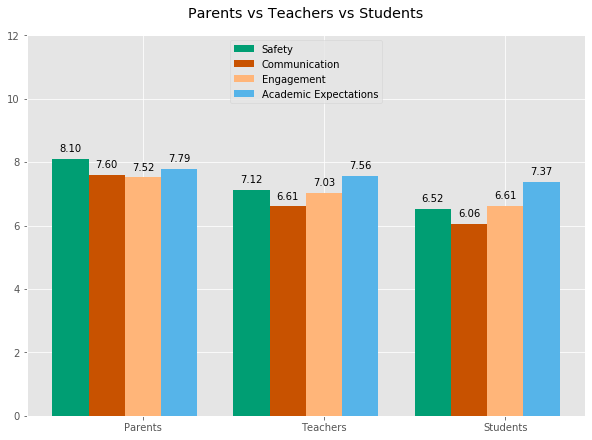

In [35]:
data = np.array([parents_means, teachers_means, students_means])
length = len(data)
width = 0.2
x = np.arange(length)
x_labels = ['Parents', 'Teachers', 'Students']
              
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(x - width, data[:,0], width, color=(0,158/255,115/255), label='Safety')
ax.bar(x, data[:,1], width, color=(200/255,82/255,0/255), label='Communication')
ax.bar(x + width, data[:,2], width, color=(255/255,181/255,121/255), label='Engagement')
ax.bar(x + (2 * width), data[:,3], width, color=(86/255,180/255,233/255), label='Academic Expectations')
plt.legend(loc='upper center')
ax.set_xticks(x + width)
ax.set_xticklabels(x_labels)
plt.ylim(0,12)
plt.title('Parents vs Teachers vs Students', y=1.03)

# Function for plot annotation
def annotate(plot, rd=".2f"):
    for p in plot.patches:
            plot.annotate(format(p.get_height(), rd), 
                   (p.get_x() + p.get_width() / 2., 
                    p.get_height()), ha = "center", 
                    va = "center", xytext = (0, 10), 
                    textcoords = "offset points"
                  )
            
annotate(ax)
plt.show()

On average we see that Parents responses was higher in rate while Teachers and Students is almost similar.
We can conclude that parents rate was high because they were not the one in the immediate environment, they lack first hand experience with the school like Teachers and Students does.

### Conclusion
 
In this project we analyzed data on NYC students SAT Scores and here are the findings 

* Students from Science, Technical and Liberal Arts Schools perform better in SAT Scores irespective of Safety, Race and Gender
* SAT Scores are not fair to Black and Hispanic students which can  be as a result of newly learning English Language
* Asian students are highly represented with High SAT Scores

__For Further Analysis__:
    
* Finding the least expensive neighborhoods that have good schools.
* Assigning scores to schools based on sat_score and other attributes.